## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Número de linhas
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# Número de usuários únicos
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Proporção de usuários convertidos
df.converted.mean() * 100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Número de vezes que 'new_page' e 'treatment' não estão alinhados
df.query("(group == 'treatment' and landing_page != 'new_page') or (group != 'treatment' and landing_page == 'new_page')").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
# Checa se existe algum valor nulo
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
{
  'unique_users': df2.user_id.nunique(),
  'dataframe_size': df2.shape[0]
}

{'unique_users': 290584, 'dataframe_size': 290585}

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated('user_id')]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(2893)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2.group == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2.group == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**R:** Não há evidência suficiente, ambas as páginas converteram em torno de 12% dos usuários e elas tem aproximadamente 50% da amostra em cada grupo, não temos uma taxa de erro aceitável para criar um teste de hipótese, o teste foi realizado também em 23 dias, prazo que pode ser não suficiente para eliminar problemas como empolgação dos usuários com uma feature nova ou rejeição da alteração dos padrões conhecidos pelos usuários já acostumados com a antiga landing page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**R:** $$H_0: p_{new} - p_{old}\leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [18]:
ab_data_converted = df2.converted.mean()

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = ab_data_converted
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = ab_data_converted
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.1212235909435001

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11977366906672908

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0014499218767710237

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for i in range(0, 10000):
    p_diffs.append(np.random.binomial(1, p_new, n_new).mean() - np.random.binomial(1, p_old, n_old).mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

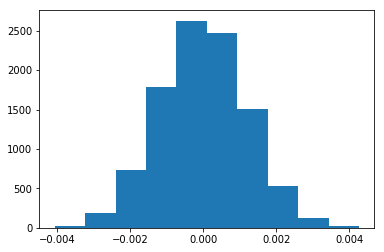

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diff = df2[df2.landing_page == 'new_page'].converted.mean() - df2[df2.landing_page == 'old_page'].converted.mean()
obs_diff

-0.0015782389853555567

In [29]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.9081

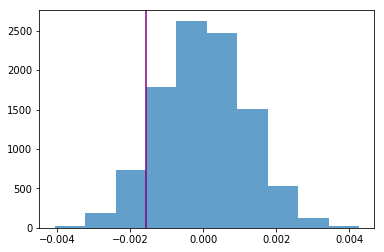

In [30]:
plt.hist(p_diffs, alpha=0.7);
plt.axvline(obs_diff, color='purple');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**R:** Foi computada a média de vezes em que o valor da diferença da conversão da nova página para a antiga na simulação, foi maior que a diferença das médias das páginas novas e antigas da base de dados. 
O valor calculado é chamado de valor-p, ele representa a probabilidade de se obter uma estatística de teste igual ou mais extrema que aquela observada em uma amostra sob a hipótese nula. Como mostrado no histograma acima, e no valor-p obtido, temos 90,81% de chance de obtermos uma estatística igual ou acima da diferença observada (-0.0015782389853555567), o que é bem acima do limite de 5% descrito no problema. Para rejeitarmos a hipótese nula, o valor-p deveria ser menor que o valor alfa (Taxa de erro limite do tipo I, que é 5%), ou seja, falhamos ao rejeitar a hipótese nula, então a página antiga deveria ser mantida.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old       = df2[df2.landing_page == "old_page"].shape[0]
n_new       = df2[df2.landing_page == "new_page"].shape[0]

{
    'convert_old': convert_old,
    'convert_new': convert_new,
    'n_old':       n_old,
    'n_new':       n_new,
}

{'convert_old': 17489, 'convert_new': 17264, 'n_old': 145274, 'n_new': 145310}

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
import statsmodels.api as sm
# O parametro alternative 'larger' é devido à propriedade da alternativa ser '>' (p_new > p_old).
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

{
    'z_score': z_score,
    'p_value': p_value,
}

{'z_score': -1.3109241984234394, 'p_value': 0.9050583127590245}

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**R:** O z-score é a quantidade de desvios padrões que o valor observado está distante da média. No caso como obtivemos um z-score de -1.3109241984234394, significa que o valor observado está a 1.3x desvios padrões distante da média para o lado esquerdo da distribuição normal (Pois é menor que a média). Temos então que a partir deste valor, a probabilidade de que qualquer outro valor observado seja maior o valor que recai sobre o z-score é de 90,50%, que corresponde a área direita da distribuição normal apartir deste ponto, já que estamos verificando uma alternativa que deve ser maior. Sendo assim, verificamos que a hipótese nula falha a ser rejeitada, já que 0.9050583127590245 (valor-p próximo ao encontrado em **j.** e **k.**) é maior que nosso alfa de 0.5. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**R:** Regressão Logística, pois possuímos variáveis categóricas, 'group' e 'landing_page', além de 'converted' que já é uma variável que aceita verdadeiro ou falso.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2_logistic = df2.copy()
# Como landing_page e group tem o mesmo comportamento, utilizarei apenas a coluna de landing_page
df2_logistic = df2_logistic.join(pd.get_dummies(df2_logistic.group))
df2_logistic = df2_logistic.drop(['timestamp', 'group', 'landing_page', 'control'], axis=1)
df2_logistic = df2_logistic.rename(columns={'treatment': 'ab_page'})
# Adicionando coluna intercept
df2_logistic['intercept'] = 1
df2_logistic.head()

,user_id,converted,ab_page,intercept
0,851104,0,0,1
1,804228,0,0,1
2,661590,0,1,1
3,853541,0,1,1
4,864975,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
lm = sm.Logit(df2_logistic['converted'], df2_logistic[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:15:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [36]:
# Devemos elevar as variáveis a exponencial para analisar os resultados, e como os coeficientes são negativos, 
# dividimos 1 pelo resultado para facilitar a análise
{
    'intercept': 1/np.exp(-1.9888), 
    'ap_page': 1/np.exp(-0.0150)
}

{'intercept': 7.3067603868728614, 'ap_page': 1.015113064615719}

A página antiga é 1.01511 vezes mais provável de converter do que a página nova.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**R:** O valor p é de 0.19.

Na parte II, nós calculamos o valor p a partir da premissa que tentavamos provar que p_new > p_old, e não levamos em consideração p_new <= p_old, portanto, na parte II observavamos um teste de apenas um lado, enquanto na parte III, temos um teste de ambos os lados. Para encontrar a equivalência podemos fazer o calculo:
1-0,19/2 = 0,905
Ou seja, temos 90,5%, semelhante ao valor-p encontrado na Parte II. O valor-p neste caso de regressão logistica, verifica se a variável independente das outras, teve algum efeito no resultado do teste.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**R:** Neste cenário de análise estamos observando apenas se o usuário efetuou ou não a compra (se a página converteu), mas não estamos levando em consideração um dado que está no conjunto de dados que é o tempo, não avaliamos quanto ao tempo ser suficiente para chegar a uma consistencia de dados, pois grande parte das pessoas reagem positivamente devido a empolgação pela novidade, ou reagem negativamente pela resistencia à mudanças, independente de a nova página ter sido melhor ou não. Então um possível fator seria desconsiderar o período de adaptação e deixar o teste rodando por mais tempo para garantir que os dados sejam mais confiáveis.
Além disso é positivo utilizar outras variáveis para saber o contexto em geral, podemos cair por exemplo em um paradoxo de simpson caso o conjunto de usuários apesar de estar quase 50% em cada um dos grupos de control e treatment, não sabemos características específicas dos usuários e pode ser que cada subconjunto de usuários que compartilham as mesmas características possam estar mal distribuídos causando assim uma interpretação equivocada.
Alguns outros dados que poderiam ser levados em consideração para análise:
- **Perfil do usuário (Faixa de idade, Região, Sexo):** Esses fatores podem interferir quanto a até mesmo a identificação do público alvo e estreitar os casos de teste para nichos específicos.
- **Preço:** Na análise feita é verificado se o usuário comprou ou não, mas não é verificado o quanto cada usuário comprou, pode ser que uma taxa de conversão pior com compras melhores seja mais eficáz para o modelo de negócio. 
- **Número de visitas antes da compra:** Um outro bom indicativo seria verificar quantas vezes um mesmo usuário visitou a página antes de fazer a compra em cada página, qual das páginas vendeu mais em apenas uma visita ou foi abandonada mais vezes na primeira visita também são pontos possíveis a se levar em consideração.
- **Fonte de onde chegou até o site:** De onde veio o usuário que entrou no site? Entrou acessando a url diretamente ou foi por meio de algum anúncio em uma rede social, ou por algum mecanismo de busca? Este fator também pode favorecer para que o usuário efetue a compra mais facilmente.

O ponto negativo de adicionar mais variáveis, é que cada vez a análise fica mais complexa, tornando mais difícil encontrar algum modelo que se encaixe na situação.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2_logistic.set_index('user_id'), how='inner')
df_new.head()

,country,converted,ab_page,intercept
user_id,,,,
834778,UK,0,0,1
928468,US,0,1,1
822059,UK,1,1,1
711597,UK,0,0,1
710616,UK,0,1,1


In [38]:
df_new.isnull().values.any()

False

In [39]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
n_country = {
    'UK': df_new[df_new.country == 'UK'].shape[0],
    'US': df_new[df_new.country == 'US'].shape[0],
    'CA': df_new[df_new.country == 'CA'].shape[0]
}
n_country

{'UK': 72466, 'US': 203619, 'CA': 14499}

In [41]:
percentage_users_country = {
    'UK': n_country['UK'] / df_new.shape[0] * 100,
    'US': n_country['US'] / df_new.shape[0] * 100,
    'CA': n_country['CA'] / df_new.shape[0] * 100
}
percentage_users_country

{'UK': 24.938055777331165, 'US': 70.07233708669438, 'CA': 4.989607135974452}

In [42]:
p_country = {
    'UK': df_new[df_new.country == 'UK'].converted.mean(),
    'US': df_new[df_new.country == 'US'].converted.mean(),
    'CA': df_new[df_new.country == 'CA'].converted.mean()
}
p_country

{'UK': 0.12059448568984076,
 'US': 0.1195468006423762,
 'CA': 0.11531829781364232}

In [43]:
proportion_new_country = {
    'UK': df_new.query("country == 'UK' and ab_page == 1").shape[0] / n_country['UK'],
    'US': df_new.query("country == 'US' and ab_page == 1").shape[0] / n_country['US'],
    'CA': df_new.query("country == 'CA' and ab_page == 1").shape[0] / n_country['CA'],
}
proportion_new_country

{'UK': 0.49824745397841746, 'US': 0.5004591909399417, 'CA': 0.5035519691013174}

In [44]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new.country))
df_new = df_new.drop(['country'], axis=1)
df_new.head()

,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,
834778,0,0,1,0,1,0
928468,0,1,1,0,0,1
822059,1,1,1,0,1,0
711597,0,0,1,0,1,0
710616,0,1,1,0,1,0


In [45]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        17:15:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [46]:
{
    'exp_UK': np.exp(0.0507),
    'exp_ES': np.exp(0.0408)
}

{'exp_UK': 1.052007243765014, 'exp_ES': 1.0416437559600236}

Em UK é 1.052 vezes mais provável que a conversão ocorra em relação ao CA, com todas outras variáveis mantidas.
Em US é 1.042 vezes mais provável que a conversão ocorra em relação ao CA, com todas outras variáveis mantidas.

Nenhum valor-p é significante suficiente, e baseado também nas proporções e porcentagens de conversão, não parece que o país tem impacto nas conversões, mesmo com o tamanho da base de dados de cada país sendo bem diferente..

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
# Z-test para UK
convert_old_UK = df_new.query('UK == 1 and ab_page == 0 and converted == 1').shape[0]
convert_new_UK = df_new.query('UK == 1 and ab_page == 1 and converted == 1').shape[0]
n_old_UK       = df_new.query('UK == 1 and ab_page == 0').shape[0]
n_new_UK       = df_new.query('UK == 1 and ab_page == 1').shape[0]

z_score_UK, p_value_UK = sm.stats.proportions_ztest([convert_new_UK, convert_old_UK], [n_new_UK, n_old_UK], alternative='larger')
z_score_UK, p_value_UK

{
    'z_score_UK': z_score_UK,
    'p_value_UK': p_value_UK,
}

{'z_score_UK': 0.4748911128778919, 'p_value_UK': 0.3174322930960848}

In [48]:
# Z-test para US
convert_old_US = df_new.query('US == 1 and ab_page == 0 and converted == 1').shape[0]
convert_new_US = df_new.query('US == 1 and ab_page == 1 and converted == 1').shape[0]
n_old_US       = df_new.query('US == 1 and ab_page == 0').shape[0]
n_new_US       = df_new.query('US == 1 and ab_page == 1').shape[0]

z_score_US, p_value_US = sm.stats.proportions_ztest([convert_new_US, convert_old_US], [n_new_US, n_old_US], alternative='larger')
z_score_US, p_value_US

{
    'z_score_US': z_score_US,
    'p_value_US': p_value_US,
}

{'z_score_US': -1.5051934564639167, 'p_value_US': 0.9338628264991603}

In [49]:
# Z-test para CA
convert_old_CA = df_new.query('CA == 1 and ab_page == 0 and converted == 1').shape[0]
convert_new_CA = df_new.query('CA == 1 and ab_page == 1 and converted == 1').shape[0]
n_old_CA       = df_new.query('CA == 1 and ab_page == 0').shape[0]
n_new_CA       = df_new.query('CA == 1 and ab_page == 1').shape[0]

z_score_CA, p_value_CA = sm.stats.proportions_ztest([convert_new_CA, convert_old_CA], [n_new_CA, n_old_CA], alternative='larger')
z_score_CA, p_value_CA

{
    'z_score_CA': z_score_CA,
    'p_value_CA': p_value_CA,
}

{'z_score_CA': -1.2968998972345893, 'p_value_CA': 0.9026671840573587}

Fazendo o Z-test para cada um dos países, o valor-p de UK é significante, já que é menor que o alfa de 0.5. Faremos a regressão logística em relação a US e CA para verificar se UK causa impacto em contexto geral.

In [50]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        17:15:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

Na abordagem baseada na visão de CA, nenhum valor-p é significante.

In [51]:
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 13 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        17:15:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Na abordagem baseada na visão de US, apesar de o valor-p vinculado a coluna de UK ser mais alto, ou seja, mais significante que os outros, ainda assim, fazendo a conversão para caso do teste de hipótese (1-(0.457/2)), obtemos um valor-p de 0.7715, que ainda está bem acima do alfa de 0.5.

<a id='conclusions'></a>
## Conclusions

Apesar de que em UK os usuários preferiram acessar a página nova, o impacto do país não é suficiente para admitir uma mudança geral, até porque a quantidade de usuários de UK representa apenas 25% do total de usuários testados. Se fosse o caso de que os usuários do e-commerce fossem de grande maioria de UK, e mantivesse a mesma proporção de conversão, poderia ser mais viável que a landing page fosse atualizada para a nova, mas no nosso contexto, não é suficiente e seria mais viável optar por manter a página antiga.